# A demo of K-Means clustering on the handwritten digits data (using LowRankModels.jl)

Adapted from http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_digits.html

In this example we apply K-Means to the digits dataset.

As the ground truth is known here, we also apply different cluster quality metrics to judge the goodness of fit of the cluster labels to the ground truth.

**IMPORTANT NOTE**: LowRankModels.jl's PCA is correct (though slower than conventional algorithms), but its K-Means does not always converge, as can be seen in the last figure. It's an ongoing effort.

In [1]:
using PyPlot    # Pkg.add("PyPlot") to install
using ScikitLearn
using PyCall
using ScikitLearn.Utils: meshgrid
using LowRankModels: PCA, KMeans

@sk_import datasets: load_digits
@pyimport sklearn.metrics as metrics
@pyimport sklearn.preprocessing as preprocessing

n_digits: 10, 	 n_samples 1797, 	 n_features 64
____________________________________________________________________________
init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette
k-means++   19.56s    NaN   0.189   0.229   0.207   0.108   0.181    -0.094
________________________________________________________________________Fitting GLRM
Iteration 10: objective value = 215.57489659627504
Fitting GLRM
Iteration 10: objective value = 1508.522178988117
Iteration 20: objective value = 1470.7605920428118

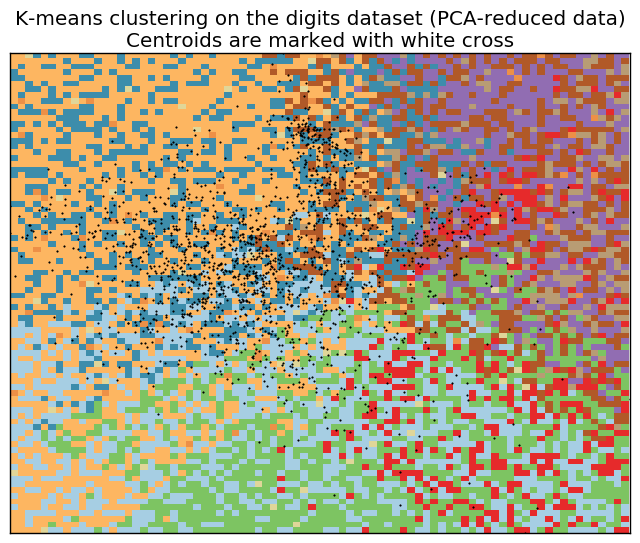


  2.009710 seconds (30.74 M allocations: 868.649 MB, 9.17% gc time)


(Any[],Any[])

In [2]:
srand(42)

digits = load_digits()
data = preprocessing.scale(digits["data"])

n_samples, n_features = size(data)
n_digits = length(unique(digits["target"]))
labels = digits["target"]

sample_size = 300

@printf("n_digits: %d, \t n_samples %d, \t n_features %d\n", n_digits, n_samples, n_features)


println("____________________________________________________________________________")
@printf("% 9s", "init    time  inertia    homo   compl  v-meas     ARI AMI  silhouette\n")

function bench_k_means(estimator, name, data)
    t0 = time()
    fit!(estimator, data)
    # This performs the "argmax" over the columns to get the labels
    #est_labels = mapslices(indmax, estimator.glrm.X, 1)[:]
    est_labels = predict(estimator, data)
    @printf("% 9s   %.2fs    %i   %.3f   %.3f   %.3f   %.3f   %.3f    %.3f\n",
            name, time()-t0, NaN,
            metrics.homogeneity_score(labels, est_labels),
            metrics.completeness_score(labels, est_labels),
            metrics.v_measure_score(labels, est_labels),
            metrics.adjusted_rand_score(labels, est_labels),
            metrics.adjusted_mutual_info_score(labels,  est_labels),
            metrics.silhouette_score(data, est_labels,
                                      metric="euclidean",
                                      sample_size=sample_size))
end

bench_k_means(KMeans(k=n_digits, max_iter=200), "k-means++", data)

print("________________________________________________________________________")

###############################################################################
# Visualize the results on PCA-reduced data

reduced_data = fit_transform!(PCA(k=2, max_iter=100), data)

kmeans = KMeans(k=n_digits, abs_tol=1.e-10, max_iter=50000, verbose=true, inner_iter=60)
fit!(kmeans, reduced_data);

#@time Z2 = pairwise(Euclidean(), hcat(xx[:], yy[:])', kmeans.glrm.Y')
#predictions = mapslices(indmin, Z2, 2)[:];

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = .02     # point in the mesh [x_min, m_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = minimum(reduced_data[:, 1]), maximum(reduced_data[:, 1])
y_min, y_max = minimum(reduced_data[:, 2]), maximum(reduced_data[:, 2])
xx, yy = meshgrid(x_min:h:x_max, y_min:h:y_max);

# Obtain labels for each point in mesh. Use last trained model.
@time Z0 = predict(kmeans, hcat(xx[:], yy[:]))

# Put the result into a color plot
Z = reshape(Z0, size(xx)...)

imshow(Z, interpolation="nearest",
       extent=(minimum(xx), maximum(xx), minimum(yy), maximum(yy)),
       cmap=PyPlot.cm[:Paired],
       aspect="auto", origin="lower")

plot(reduced_data[:, 1], reduced_data[:, 2], "k.", markersize=2)
# Plot the centroids as a white X
#centroids = kmeans[:cluster_centers_]
#scatter(centroids[:, 1], centroids[:, 2],
#        marker="x", s=169, linewidths=3,
#        color="w", zorder=10)
title("K-means clustering on the digits dataset (PCA-reduced data)\n"*"Centroids are marked with white cross")
xlim(x_min, x_max)
ylim(y_min, y_max)
xticks(())
yticks(())